# 📌 : Klasifikasi Telur Ayam **Fertile** dan **Infertile** Menggunakan CNN (TensorFlow)

## *Deskripsi:*

Notebook ini membangun model klasifikasi biner menggunakan Convolutional Neural Network (CNN) untuk mendeteksi telur ayam fertile dan infertile berdasarkan citra. Dataset sudah mencakup augmentasi dan dibagi ke dalam data train, validasi, dan test.

**[Source Dataset](https://universe.roboflow.com/eggs-i8jui/egggs3/dataset/1)** ❔

---

## Penjelasan Augmentasi Dataset yang Digunakan

Dataset yang digunakan dalam notebook ini sudah dilengkapi dengan augmentasi data bawaan, sehingga tidak perlu menambahkan augmentasi lagi di tahap preprocessing. Augmentasi ini melibatkan teknik-teknik berikut untuk memperkaya variasi data dan mencegah overfitting pada model:

1. **Auto-Orient**: Menerapkan orientasi otomatis pada gambar jika diperlukan.
   
2. **Resize**: Mengubah ukuran gambar menjadi 640x640 piksel.

3. **Augmentasi pada Citra**:
    - **Crop**: 0% Minimum Zoom dan 20% Maximum Zoom (untuk pemotongan acak).
    - **Rotasi**: Gambar dapat diputar antara -15° hingga +15°.
    - **Shear**: Pergeseran horizontal dan vertikal hingga ±10°.

4. **Bounding Box**:
    - **Crop**: 0% Minimum Zoom dan 20% Maximum Zoom pada Bounding Box.
    - **Rotasi**: Rotasi gambar di dalam Bounding Box antara -10° hingga +10°.
    - **Shear**: Pergeseran Bounding Box horizontal dan vertikal hingga ±5°.

Augmentasi ini dilakukan untuk memastikan bahwa model dapat belajar dari data yang lebih beragam dan lebih kuat terhadap variasi di dunia nyata, seperti rotasi, zoom, atau pergeseran objek dalam gambar.

Untuk tahap preprocessing di notebook ini, hanya dilakukan normalisasi pada data citra dengan mengatur `rescale=1./255`, yang akan mengubah nilai pixel gambar agar berada di rentang [0, 1].


In [2]:
import os

def print_folder_tree(startpath, prefix=""):
    items = sorted(os.listdir(startpath))
    dirs = [item for item in items if os.path.isdir(os.path.join(startpath, item))]
    pointers = ['├── '] * (len(dirs) - 1) + ['└── ']

    for pointer, folder in zip(pointers, dirs):
        path = os.path.join(startpath, folder)
        print(prefix + pointer + folder)
        extension = '│   ' if pointer == '├── ' else '    '
        print_folder_tree(path, prefix + extension)

root_dir = "./dataset"
print(root_dir)
print_folder_tree(root_dir)


./dataset
├── test
│   ├── fertile
│   └── unfertile
├── train
│   ├── fertile
│   └── unfertile
└── valid
    ├── fertile
    └── unfertile


**🔹 Step 1: Import Library**

*Import semua library yang diperlukan untuk membangun, melatih, dan mengevaluasi model klasifikasi, termasuk TensorFlow, Keras, sklearn, matplotlib, dan lainnya.*

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os
import numpy as np


**🔹 Step 2: Menentukan Path Dataset**

*Tentukan direktori untuk dataset train, validasi, dan test yang sudah disiapkan dan dipisahkan sebelumnya.*



In [4]:
# Step 2: Set Dataset Path
base_dir = "./dataset"

train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

**🔹 Step 3: Preprocessing Data**

*Melakukan normalisasi dengan rescale=1./255 untuk semua subset data. Dataset sudah memiliki augmentasi sebelumnya, sehingga tidak ditambahkan lagi di sini.*

In [5]:
# Step 3: Data Preprocessing
# Augmentasi sudah diterapkan di dataset, hanya rescale untuk normalisasi
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1362 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model("best_model.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open("final_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\T0MM11Y\AppData\Local\Temp\tmp3eythxqk\assets


INFO:tensorflow:Assets written to: C:\Users\T0MM11Y\AppData\Local\Temp\tmp3eythxqk\assets


**🔹 Step 4: Membangun Model CNN **

*Membangun arsitektur CNN dengan 3 blok konvolusi dan 1 lapisan Dense, serta Dropout dan Regularization untuk mencegah overfitting.*

In [7]:
# Step 4: Build CNN Model
model = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification: fertile/unfertile
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

**🔹 Step 5: Kompilasi Model**

*Mengkompilasi model dengan optimizer Adam dan loss function binary_crossentropy, karena ini adalah kasus klasifikasi biner.*

In [28]:
# Step 5: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


**🔹 Step 6: Menentukan Callback**

*Menambahkan EarlyStopping dan ModelCheckpoint untuk menghentikan pelatihan dini jika model tidak membaik dan menyimpan model terbaik berdasarkan val_loss.*

In [29]:
# Tambahkan EarlyStopping untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_loss
checkpoint = ModelCheckpoint(
    './model/best_model.h5',  # Gunakan format .keras untuk penyimpanan modern
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

**ConvertToTFlite**

In [31]:
import tensorflow as tf

# Muat model Keras terbaik
model = tf.keras.models.load_model('./model/best_model.h5')

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke format TFLite dan disimpan sebagai 'best_model.tflite'")

INFO:tensorflow:Assets written to: C:\Users\T0MM11Y\AppData\Local\Temp\tmpmrnken5q\assets


INFO:tensorflow:Assets written to: C:\Users\T0MM11Y\AppData\Local\Temp\tmpmrnken5q\assets


Model berhasil dikonversi ke format TFLite dan disimpan sebagai 'best_model.tflite'


**🔹 Step 7: Melatih Model**

*Melatih model pada data train dan validasi selama maksimal 20 epoch, dengan callback diterapkan. Proses ini akan menampilkan metrik akurasi dan loss setiap epoch.*

In [30]:
# Tambahkan callbacks ke dalam proses pelatihan
callbacks = [early_stopping, checkpoint]

# Step 7: Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
43/43 [==============================] - 48s 1s/step - loss: 1.1114 - accuracy: 0.7327 - val_loss: 0.6101 - val_accuracy: 0.8039
Epoch 2/20
43/43 [==============================] - 46s 1s/step - loss: 0.4762 - accuracy: 0.8583 - val_loss: 0.5036 - val_accuracy: 0.8431
Epoch 3/20
43/43 [==============================] - 46s 1s/step - loss: 0.3769 - accuracy: 0.9023 - val_loss: 0.4177 - val_accuracy: 0.8627
Epoch 4/20
43/43 [==============================] - 46s 1s/step - loss: 0.3727 - accuracy: 0.9163 - val_loss: 0.3309 - val_accuracy: 0.9216
Epoch 5/20
43/43 [==============================] - 48s 1s/step - loss: 0.2862 - accuracy: 0.9435 - val_loss: 0.2129 - val_accuracy: 1.0000
Epoch 6/20
43/43 [==============================] - 47s 1s/step - loss: 0.2211 - accuracy: 0.9655 - val_loss: 0.2251 - val_accuracy: 0.9412
Epoch 7/20
43/43 [==============================] - 48s 1s/step - loss: 0.2080 - accuracy: 0.9692 - val_loss: 0.3764 - val_accuracy: 0.9020
Epoch 8/20
43/43 [==

**🔹 Step 8: Evaluasi Model pada Data Uji**

*Menghitung akurasi dan loss model terhadap dataset pengujian untuk mengetahui performa generalisasi model.*

In [ ]:
# Step 8: Evaluate Model on Test Dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9629 - loss: 0.1645
Test Accuracy: 96.00%
Test Loss: 0.1730


**🔹 Step 9: Membuat Confusion Matrix**

*Menghitung dan memvisualisasikan confusion matrix dari hasil prediksi untuk mengevaluasi performa klasifikasi secara lebih rinci.*

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
Confusion Matrix:
[[22  1]
 [ 1 26]]


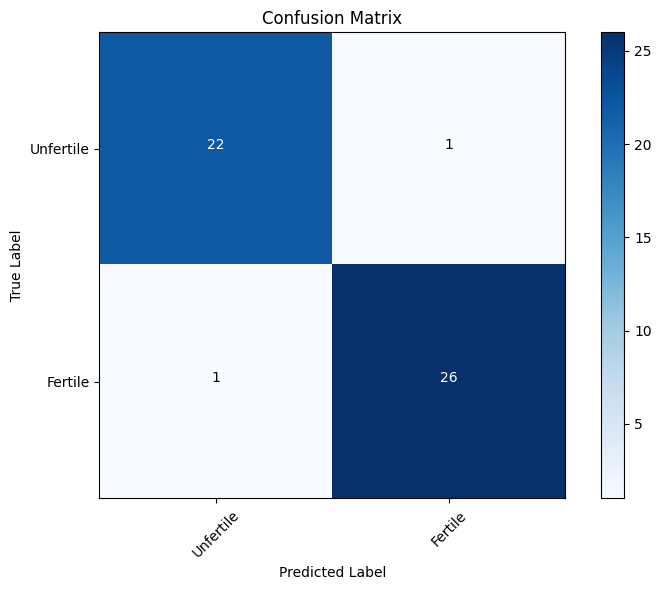

In [ ]:
# Step 9: Confusion Matrix
# Predict labels on the test dataset
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Generate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Unfertile', 'Fertile'], rotation=45)
plt.yticks(tick_marks, ['Unfertile', 'Fertile'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Annotate confusion matrix
thresh = conf_matrix.max() / 2.0
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f'{conf_matrix[i, j]}', horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


**🔹 Step 10: Menampilkan Classification Report**

*Menampilkan metrik evaluasi model seperti precision, recall, dan f1-score untuk masing-masing kelas (fertile dan unfertile).*

In [ ]:
# Step 10: Classification Report
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=['Unfertile', 'Fertile']))


Classification Report:
              precision    recall  f1-score   support

   Unfertile       0.96      0.96      0.96        23
     Fertile       0.96      0.96      0.96        27

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



**🔹 Step 11: Plot ROC Curve**

*Menggambar ROC Curve dan menghitung AUC untuk mengukur kinerja klasifikasi secara keseluruhan.*

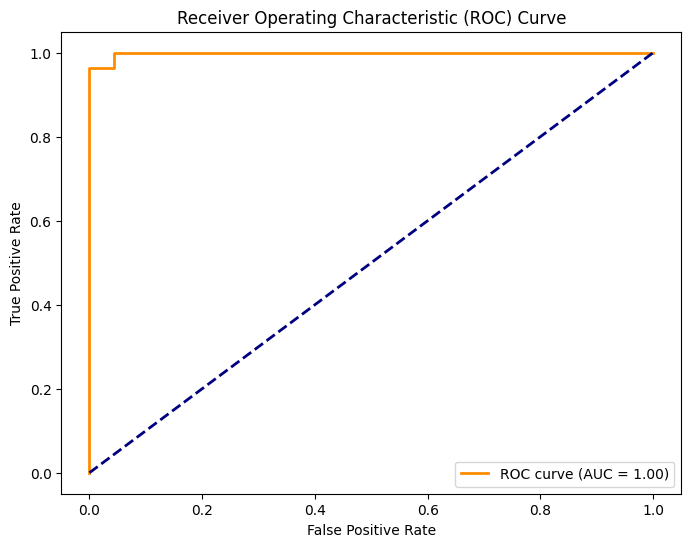

In [ ]:
# Step 11: ROC Curve
fpr, tpr, _ = roc_curve(test_generator.classes, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**🔹 Step 12: Menyimpan Model dalam Format Keras**

*Menyimpan model terlatih dalam format .keras yang direkomendasikan oleh TensorFlow untuk digunakan atau diekspor di masa depan.*


In [3]:
# Step 12: Save Model in Keras Native Format
model.save('/content/drive/MyDrive/ColabNotebooks/EggClassification~11/models/final_model.keras')
print("Model saved to /content/drive/MyDrive/ColabNotebooks/EggClassification~11/models/final_model.keras")

Model saved to /content/drive/MyDrive/ColabNotebooks/EggClassification~11/models/final_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)
